# Définition de l'environnement de travail

In [5]:
#Import du module GIS de l'API Python ArcGIS pour intéragir avec la plateforme ArcGIS
from arcgis.gis import GIS

#Import des librairies nécessaire au deep learning
import torch
from fastai.conv_learner import *
from fastai.dataset import *

#Définition de la variable PATH qui servira à sauvegarder et charger les fichiers 
from pathlib import Path
PATH = Path(r"C:\demonstration\pleniere\machinelearning\data")

# Préparation des données

## Chargement des données

In [6]:
#Création d'un dictionnaire contenant le mappage de chaque partie d'image vers les boîtes englobantes (bounding boxes)
import pickle
tilemapping = pickle.load(open(PATH/'tilemapping3.pkl', 'rb'))
tilemapping1 = pickle.load(open(PATH/'tilemapping2.pkl', 'rb'))
tilemapping3 = pickle.load(open(PATH/'tilemapping4.pkl', 'rb'))
tilemapping = {**tilemapping, **tilemapping1, **tilemapping3}

len(tilemapping)

123450

In [7]:
#Import de modules nécessaires au traçage de graphiques
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

#Définition de fonctions utiles au traçage de graphiques
def get_color(text):
    if text=='bg':
        c = 'gray'
    elif text=='pool ':
        c = 'white'
    else:
        c = 'yellow'
    return c

def draw_outline(obj, width):
    obj.set_path_effects([patheffects.Stroke(linewidth=width, foreground='black'), patheffects.Normal()])

def draw_bbox(ax, bbox, text=None, i=None, pr=None):    
    c = get_color(text)
    patch = ax.add_patch(patches.Rectangle(xy=(bbox[1], bbox[0]), width=bbox[3]-bbox[1],
                                           height=bbox[2]-bbox[0], 
                                           fill=False, edgecolor=c, lw=2))
    draw_outline(patch, 4)
    if i is not None:
        text = text
    if pr is not None:
        text = text + f' {pr:.2f}'
    if text is not None:
        t = ax.text(bbox[1], bbox[0], s=text, color='white', fontsize=12,
                    verticalalignment='bottom', weight='bold') #,bbox=dict(facecolor=c, pad=2))
        draw_outline(t, 1)

def draw_img_bboxes(ax, img, bboxes, classes=None, prs=None, thresh=0.3):
    
    if prs is None:  
        prs  = [None]*len(bboxes)
    if classes is None: 
        classes = [1]*len(bboxes)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img);
    for i, (bbox, c, pr) in enumerate(zip(bboxes, classes, prs)):
        if((bbox[3] - bbox[1] > 0) and (pr is None or pr > thresh)):
            try: cat = categories[c]
            except: cat = 'bg'
            draw_bbox(ax, bbox, cat, i, pr)
            
def draw_image(filename):
    fig, ax = plt.subplots(figsize=(4,4))
    img = open_image(PATH / 'images' / filename)
    
    bboxes=[]
    for center in tilemapping[filename]:
        bboxes.append(get_bbox(center))
        
    draw_img_bboxes(ax, img, bboxes)

In [8]:
#Définition des catégories présentes dans l'image
categories = {0: 'sol', 1: 'piscine'}

sz = 224
objsize = 30

#Conversion des boîtes englobantes en texte
def get_bboxes_str(filename):
    bboxes = ''
    for center in tilemapping[filename]:
        bboxes = bboxes + ' '.join(str(c) for c in (get_bbox(center)))
        bboxes = bboxes + ' '
    return bboxes

#Récupération des coordonnées de l'emplacement des centres des boîtes englobantes
def get_bbox(center):
    xpix, ypix = int(sz*center[0]), int(sz*(1.0-center[1]))
        
    xmin, xmax = xpix - objsize//2, xpix + objsize//2 + 2
    ymin, ymax = ypix - objsize//2, ypix + objsize//2 + 2
    xmin = xmin # if xmin > 0 else 0
    ymin = ymin # if ymin > 0 else 0
    xmax = xmax # if xmax < sz else sz
    ymax = ymax # if ymax < sz else sz
    return [ymin, xmin, ymax, xmax]

#Création d'un dictionnaire
bboxes_dict = {name: get_bboxes_str(name).strip()
                   for name, centers in tilemapping.items()}

#Création d'un data frame
bboxes_df = pd.DataFrame.from_dict(bboxes_dict, orient='index').reset_index()
bboxes_df.columns = ['fn', 'bbox']

#Enregistrement dans un fichier csv
MULTIBOX_CSV = PATH/'bboxes.csv'
bboxes_df.sort_values(by='fn', inplace=True)
bboxes_df.to_csv(MULTIBOX_CSV, index=False)
bboxes_df.head()

,fn,bbox
0,0000_00.jpg,182 137 214 169 131 127 163 159 99 21 131 53 4...
1,0000_01.jpg,195 58 227 90 145 48 177 80
2,0000_02.jpg,70 179 102 211 19 169 51 201 -13 64 19 96 168 ...
3,0000_03.jpg,155 150 187 182 104 140 136 172 72 35 104 67 1...
4,0000_04.jpg,101 177 133 209 51 167 83 199 18 62 50 94 199 ...


In [9]:
#Calcul du nombre de colonne des objets pour chaque ligne
bboxes_df = pd.read_csv(MULTIBOX_CSV)
bboxes_df['n'] = bboxes_df['bbox'].apply(lambda x: len(x.split(' ')) // 4)

object_classes = np.array([np.ones(row['n']).astype(int) for index, row in bboxes_df.iterrows()])

#Séparation des données en un jeu d'entraînement et un jeu de validation avec la fonction get_cv_idxs de fast.ai
val_idxs = get_cv_idxs(len(object_classes))
((val_classes, train_classes),) = split_by_idx(val_idxs, object_classes)

len(val_classes), len(train_classes)

(24690, 98760)

## Paramétrage du modèle

In [10]:
model = resnet34                 # Modèle à utiliser pour le transfer learning
sz = 224                         # Taille des images à utiliser
bs = 64                          # Taille du batch
JPEGS = 'images'                 # Fichier contenant les images

#Définition des transformations apportées aux images
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.5, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]

tfms = tfms_from_model(model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)

#Création de l'objet model_data qui servira à la création du modèle de données
model_data = ImageClassifierData.from_csv(PATH, JPEGS, MULTIBOX_CSV, tfms=tfms, continuous=True)

In [11]:
#Création d'une classe pour ajouter les classes (y2) des boîtes englobantes (y1) au modèle de données
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y1 = self.ds[i]
        y2 = self.y2[i]
        return (x, (y1, y2))

In [12]:
#Ajout des classes dans l'objet model_data
train_dataset = ConcatLblDataset(model_data.trn_ds, train_classes)
val_dataset   = ConcatLblDataset(model_data.val_ds, val_classes)

model_data.trn_dl.dataset = train_dataset
model_data.val_dl.dataset = val_dataset

## Afficher un échantillon d'images étiquetées

In [13]:
#Création d'une fonction pour afficher un échantillon des données d'entraînement
x, y = to_np(next(iter(model_data.val_dl)))
x    = model_data.val_ds.ds.denorm(x)

def show_training_data():
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for i,ax in enumerate(axes.flat):
        draw_img_bboxes(ax, x[i], y[0][i].reshape(-1, 4), y[1][i])
    plt.tight_layout()

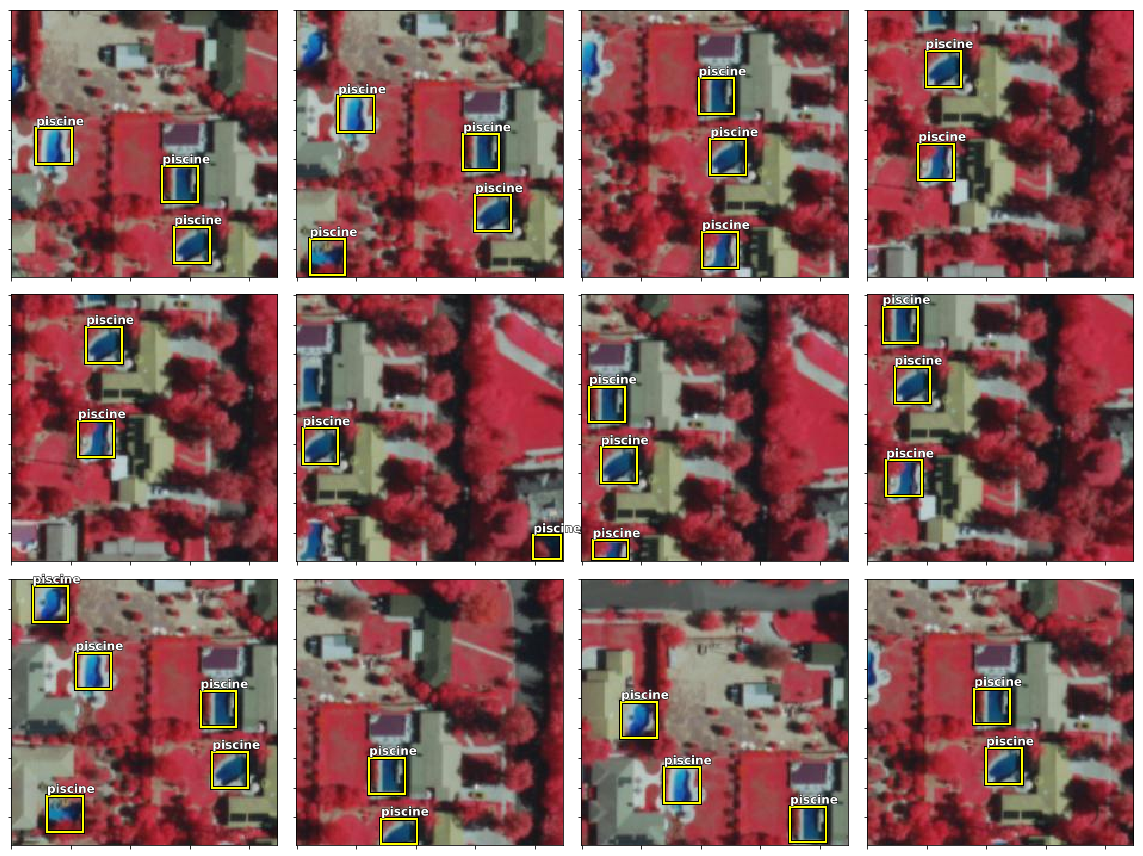

In [14]:
show_training_data()

## Afficher un exemple de transformation appliquée aux images

In [15]:
#Création d'une fonction pour afficher un exemple de transformation appliquée aux images (data augmentation)
def get_augs():
    data = ImageClassifierData.from_csv(PATH, JPEGS, MULTIBOX_CSV, tfms=tfms, continuous=True)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(12)])

def plots(ims, figsize=(16, 12), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

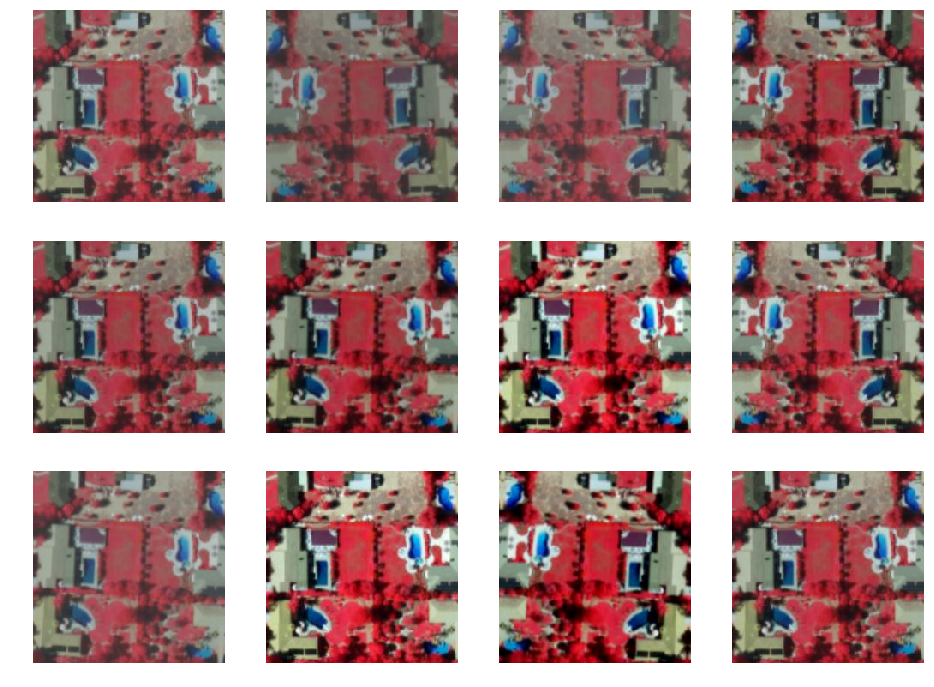

In [16]:
plots(ims, rows=3)

# Entraînement du modèle

## Définition et paramétrages du modèle

In [17]:
#Définition de l'architecture du modèle
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()                # batch size, num filters, width, height
    x = x.permute(0, 3, 2, 1).contiguous()   # batch_size, 
    return x.view(bs, -1, nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1) # nclasses
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) # bboxes
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c, o2c, o3c], dim=1),
                torch.cat([o1l, o2l, o3l], dim=1)]

In [18]:
#Paramétrage des découpages, zoom etc. sur les images
def hw2corners(ctr, hw): 
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]

anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

id2cat = list(categories.values())
cat2id = {v:k for k,v in enumerate(id2cat)}

n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

n_clas, n_act

(3, 63)

In [19]:
#Paramétrage de l'architecture du réseau de neurone
f_model = model #définition du modèle de base pour le transfer learning
md = model_data #définition du modèle de données

drop=0.4

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

## Définition des métriques 

In [20]:
#Définition des fonctions de perte (loss functions)
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    try:
        inter = intersect(box_a, box_b)
        union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
        return inter / union
    except:
        return 0.

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    try:
        xx = ((bbox[:,2]-bbox[:,0])>0).nonzero()
        bb_keep = xx[:,0]
    except:
        return None, None
    
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:] # [-1, 1]/2 + 1 = [0.5, 1.5] * anchor ht, w
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)             # bbox, class from target
    if bbox is None:
        return 0.0, 0.0
    a_ic = actn_to_bb(b_bb, anchors)           # predicted bbox
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)  # binary cross entropy
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0.,0. # class loss, location loss
    for b_c, b_bb, bbox, clas in zip(*pred, *targ): 
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [21]:
#Forcer l'utilisation de la GPU pour les objets suivants
anchors = anchors.cuda();
grid_sizes = grid_sizes.cuda(); 
anchor_cnr = anchor_cnr.cuda()

## Entraînement 

In [22]:
#Paramétrage des taux d'apprentissage (differential learning rate annealing)
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

 78%|█████████████████████████████████████████████████              | 1202/1544 [12:18<06:12,  1.09s/it, loss=1.71e+03]

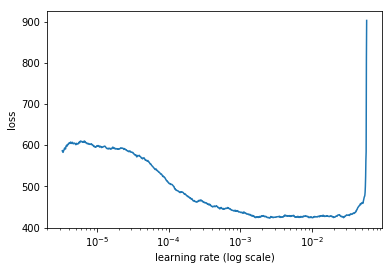

In [23]:
#Recherche du meilleur taux d'apprentissage avec lr_find()
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [24]:
#fit() renvoit 3 colonnes: training loss, validation loss et accuracy  
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                                                                                         
    0      378.486609 379.216027
    1      362.112174 360.717929                                                                                       
    2      355.150035 349.418617                                                                                       
    3      354.07913  342.066828                                                                                       


[array([342.06683])]

In [25]:
#2ème fit()
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                                                                                         
    0      359.698908 349.694553
    1      354.112366 343.454137                                                                                       
    2      344.542457 336.140575                                                                                       
    3      341.714867 330.625956                                                                                       


[array([330.62596])]

In [26]:
#Gèle (freeze) de toutes les couches ResNet à l'exception des deux dernières, les moins complexes 
#(Cellule à exécuter 2 fois)
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                                                                                         
    0      193.274366 179.031842
    1      146.036201 133.250131                                                                                       
    2      115.65315  119.868772                                                                                       
    3      101.474259 101.99798                                                                                        


[array([101.99798])]

In [27]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                                                                                         
    0      114.326422 115.714056
    1      94.441139  103.117221                                                                                       
    2      82.247772  97.097018                                                                                        
    3      69.943171  92.900243                                                                                        


[array([92.90024])]

In [28]:
#Changement de la fonction de perte (loss function) en perte focale (focal loss)    
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

 74%|█████████████████████████████████████████████████▋                 | 1144/1544 [14:54<04:21,  1.53it/s, loss=74.5]

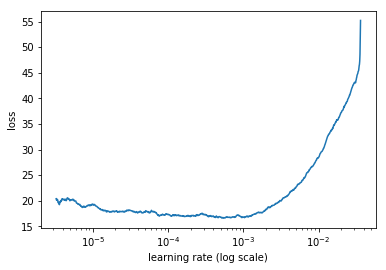

In [29]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [30]:
learn.fit(lrs/10, 1, cycle_len=4, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                         
    0      14.906015  21.963979 
    1      14.733914  20.81321                                                                                         
    2      13.830514  19.640558                                                                                        
    3      13.402632  20.216914                                                                                        


[array([20.21691])]

In [31]:
#Gèle (freeze) de toutes les couches ResNet à l'exception des deux dernières, les moins complexes
learn.freeze_to(-2)
learn.fit(lrs/50, 1, cycle_len=4, use_clr=(20,10))
learn.save("model_piscine")

epoch      trn_loss   val_loss                                                                                         
    0      13.016982  20.109052 
    1      12.797226  20.489959                                                                                        
    2      12.641209  20.491441                                                                                        
    3      12.719107  20.336972                                                                                        


In [32]:
#Dégèle (unfreeze) de toutes les couches et paramétrage du modèle final
learn.unfreeze()
learn.fit(lrs/250, 1, cycle_len=4, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                         
    0      15.484841  21.683484 
    1      14.87786   21.285528                                                                                        
    2      14.506043  21.042656                                                                                        
    3      14.358163  21.356469                                                                                        


[array([21.35647])]

# Validation

## Détection des piscines dans le jeu de validation

In [33]:
learn.load('model_piscine')

In [34]:
#Définition d'une fonction de suppression des non-maxima (non-maximum suppression)
#pour ignorer les boîtes englobantes qui se chevauchent
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  #Tri dans l'ordre croissant
    idx = idx[-top_k:]  #Index des k valeurs les plus hautes
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  #Index des valeurs actuelles les plus élevées
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  #Supprimer les éléments conservé de la visualisation
        #Chargement des bboxes des valeurs les plus élevées suivantes
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        #Enregistrer les maximums des éléments avec le score le plus élevé suivant
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        #Vérification de la taille de xx1, xx2... après chaque itération
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        #IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # Stockage des résultats dans IoU
        #Conserver uniquement les éléments avec un IoU (chevauchement)
        idx = idx[IoU.le(overlap)]
    return keep, count

In [35]:
#Sortir un batch
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [36]:
#Suppression des non-maxima et comparaison
def show_results(idx, thresh=0.25, overlap=0.1):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > thresh
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, overlap, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if cc == []:
        cc = [[0]]
    if out1 == []:
        out1 = [torch.Tensor()]
    if out2 == []:
        out2 = [torch.Tensor()]
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(15, 45))
    
    torch_gt(ax2, ima, out2, cc, out1, 0.)
    title1_str = 'objet prédit # '+ str(len([x for x in out1 if x > 0]))
    ax2.text(0,-10,title1_str)
    
    if bbox is None:
        bbox = torch.Tensor([0,0,0, 0])
    if clas is None:
        clas = torch.Tensor(0)
    torch_gt(ax3, ima, bbox, clas, None, 0.)
    title2_str = 'objet réel # '+ str(len(clas))
    ax3.text(0,-10,title2_str)
    
    show_img(ima, ax=ax1)
    title3_str = md.val_ds.ds.fnames[i]
    ax1.text(0,-10,title3_str)
    ax1.grid(False)    
    
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f''
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])    
            
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

## Comparaison des images, des objets étiquetés et des prédictions

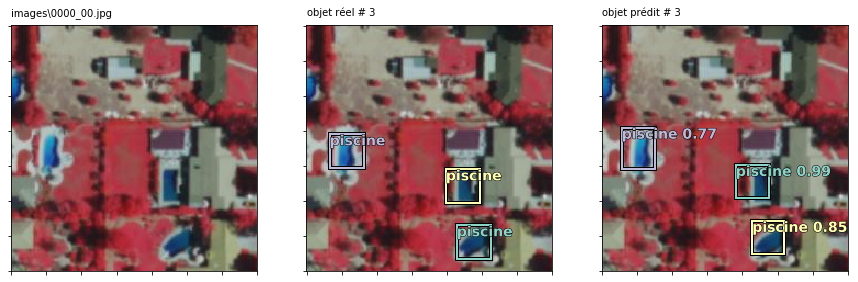

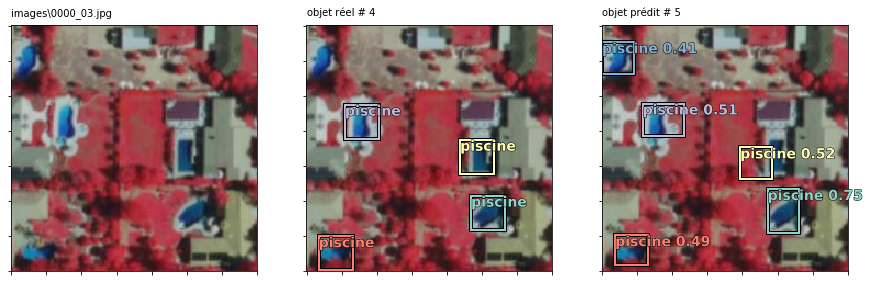

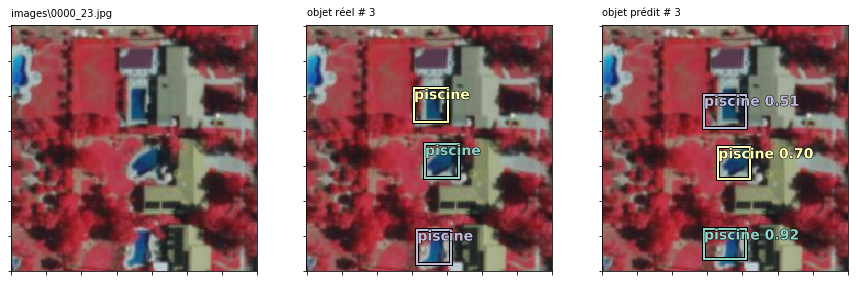

In [37]:
#Visualisation
for i in range(3):
    show_results(i, overlap=0.05)

## Précision moyenne

In [275]:
from statistics import mean
import itertools  

#Suppression des non-maxima et comparaison
def show_score(thresh=0.25, overlap=0.1):
    sc = []
    for idx in range(64):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()

        conf_scores = b_clas[idx].sigmoid().t().data

        out1,out2,cc = [],[],[]
        for cl in range(0, len(conf_scores)-1):
            c_mask = conf_scores[cl] > thresh
            if c_mask.sum() == 0: continue
            scores = conf_scores[cl][c_mask]
            l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
            boxes = a_ic[l_mask].view(-1, 4)
            ids, count = nms(boxes.data, scores, overlap, 50)
            ids = ids[:count]
            out1.append(scores[ids].tolist())
            sc.append(scores[ids].tolist())
            out2.append(boxes.data[ids])
            cc.append([cl]*count)
    
    moyenne= np.mean(list(itertools.chain(*sc)))
    return moyenne

In [276]:
show_score()

0.7116720999749202